# Data Intern Challenge

This notebook was created to solve the data challenge for intern applicants and the questions/requirements will be explained as we go.

## Imports and database connection

First, some libraries will be imported and the connection with the database will be created.

In [55]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
connection = psycopg2.connect(
    database="postgres",
    user="read_only_user",
    password="banking123",
    host="db-stone.cjepwwjnksng.us-east-1.rds.amazonaws.com",
    port='5432'
)

In [4]:
cursor = connection.cursor()
#Display the PostgreSQL version installed
cursor.execute("SELECT version();")
record = cursor.fetchone()
print("You are connected into the - ", record,"\n")

You are connected into the -  ('PostgreSQL 11.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.3 20140911 (Red Hat 4.8.3-9), 64-bit',) 



## First exercise

1. Extract and analyze the data in the database in order to answer the following questions. Provide a description and/or comments for each solution.

- What is the average `age` of the customers in the database?

To answer this question, we will first import the `customers` table into a DataFrame, then take a look in its columns.

In [7]:
customers = pd.read_sql("SELECT * FROM CUSTOMERS", connection)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674 entries, 0 to 5673
Data columns (total 4 columns):
id               5674 non-null object
age              5674 non-null int64
segment          5674 non-null object
vintage_group    5674 non-null object
dtypes: int64(1), object(3)
memory usage: 177.4+ KB


In [30]:
customers.head()

,id,age,segment,vintage_group
0,CC25034,35,Diamond,VG1
1,CC59625,22,Diamond,VG1
2,CC69314,33,Diamond,VG1
3,CC67036,46,Diamond,VG1
4,CC25597,44,Diamond,VG1


Now that we know its columns, we can calculate the average age on this database.

In [10]:
print("The average age of the customers in the database is", np.average(customers.age))

The average age of the customers in the database is 35.059922453295734


It is interesting to see that the average age is lower than the average age of the brazilian entrepreneur, which is 44.7 years old according to SEBRAE (https://datasebrae.com.br/perfil-dos-empresarios/, data from 2016). This may indicate that the Conta Stone public is, in general, younger.

To have a better understanding of the age distribution, we can see the percentiles below:

In [32]:
customers.age.describe()

count    5674.000000
mean       35.059922
std         8.962637
min        20.000000
25%        27.000000
50%        35.000000
75%        43.000000
max        50.000000
Name: age, dtype: float64

The percentiles show that 75% of the dataset has 43 years old or less and the older person has 50.

Obs: alternative query to get the result directly: `SELECT AVG(age) FROM customers`

- How is the `card_family` ranked based on the `credit_limit` given to each card?

For this question, we will analyze the information on the other tables first.

In [11]:
cards = pd.read_sql("SELECT * FROM cards", connection)
transactions = pd.read_sql("SELECT * FROM transactions", connection)
frauds = pd.read_sql("SELECT * FROM frauds", connection)

In [12]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
card_number     500 non-null object
card_family     500 non-null object
credit_limit    500 non-null int64
customer_id     500 non-null object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
id                  10000 non-null object
card_number         10000 non-null object
transaction_date    10000 non-null object
value               10000 non-null int64
segment             10000 non-null object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [14]:
frauds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
transaction_id    109 non-null object
fraud_flag        109 non-null bool
dtypes: bool(1), object(1)
memory usage: 1.1+ KB


The information that we want is only on the cards table, therefore we will explore this table now:

In [33]:
cards.head()

,card_number,card_family,credit_limit,customer_id
0,8638-5407-3631-8196,Premium,530000,CC67088
1,7106-4239-7093-1515,Gold,18000,CC12076
2,6492-5655-8241-3530,Premium,596000,CC97173
3,2868-5606-5152-5706,Gold,27000,CC55858
4,1438-6906-2509-8219,Platinum,142000,CC90518


In [41]:
cards_grouped_by_family = cards[['card_family', 'credit_limit']].groupby('card_family')

In [47]:
cards_grouped_by_family.describe()

credit_limit                                                    \
                   count           mean            std       min       25%   
card_family                                                                  
Gold               181.0   27878.453039   13495.127921    2000.0   17000.0   
Platinum           112.0  131294.642857   43272.369811   51000.0  101500.0   
Premium            207.0  514763.285024  232013.740397  108000.0  325000.0   

                                           
                  50%       75%       max  
card_family                                
Gold          28000.0   38000.0   50000.0  
Platinum     136500.0  166250.0  200000.0  
Premium      516000.0  710000.0  899000.0

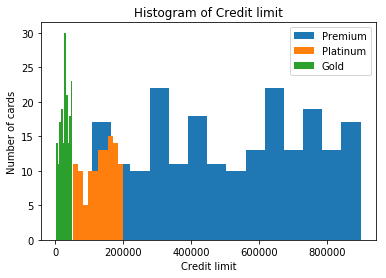

In [72]:
plt.title('Histogram of Credit limit')
plt.xlabel('Credit limit')
plt.ylabel('Number of cards')
plt.hist(cards[cards.card_family == 'Premium']['credit_limit'].values, label='Premium', bins=14)
plt.hist(cards[cards.card_family == 'Platinum']['credit_limit'].values, label='Platinum')
plt.hist(cards[cards.card_family == 'Gold']['credit_limit'].values, label='Gold')
plt.legend(loc='best')
plt.show()

With the plot we can see the `family_card` ranking given the `credit_limit`. In general: `Gold < Platinum < Premium`.

For Gold, the maximun value is smaller than the smaller value for Platinum, therefore the division between them is easier to identify. When comparing Platinum and Premium, there is a overlap in a area of the graph, but  more than 75% of the Premium cards have greater limit than the maximun Platinum limit. Besides that, the Premium maximun value and the Premium range of values are way greater than the Platinum.

- For the transactions flagged as fraud, what are the `id`s of the transactions with the highest value?

For this question, we need to join the `transactions` table with the `frauds`.

In [75]:
frauds.fraud_flag.unique()

array([ True])

In [81]:
fraud_transactions = frauds.merge(transactions, left_on='transaction_id', right_on='id')
fraud_transactions.head()

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
0,CTID50558449,True,CTID50558449,4246-1369-3659-8804,2016-05-06,6984,SEG23
1,CTID55936882,True,CTID55936882,1336-9200-1264-2551,2016-11-29,34367,SEG21
2,CTID63762180,True,CTID63762180,8528-6154-7390-5081,2016-12-05,44550,SEG15
3,CTID76723439,True,CTID76723439,7908-2695-7391-7499,2016-09-15,48275,SEG16
4,CTID21246201,True,CTID21246201,2524-4184-5908-6750,2016-02-29,35751,SEG25


In [95]:
highest_value_fraud = fraud_transactions[fraud_transactions.value == fraud_transactions.value.max()]
highest_value_fraud

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
6,CTID20567160,True,CTID20567160,3295-6390-4452-7199,2016-10-08,49155,SEG16


In [101]:
print("The transaction id flagged as fraud with the highest value is:", highest_value_fraud['id'].values[0])

The transaction id flagged as fraud with the highest value is: CTID20567160


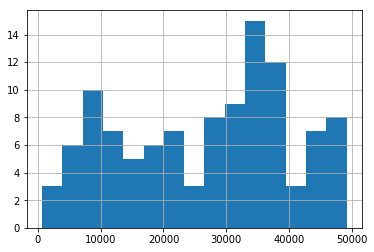

In [107]:
fraud_transactions.value.hist(bins=15)

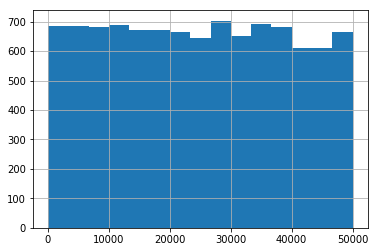

In [108]:
transactions.value.hist(bins=15)

While the transactions value distribution tends to be uniform, the value of flagged transactions tends to be a little left skewed.

2. Analysis:

    - Analyze whether or not the fraudulent transactions are somehow associated to the other features of the dataset. Explain your results.

In [6]:
# Closing the database connection
cursor.close()
connection.close()
print("PostgreSQL connection is now closed")

PostgreSQL connection is now closed
